In [19]:
import csv
import re
from collections import Counter
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import yaml
import os
config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )

def safe_eval(s):
    try:
        s = s.strip().strip("'\"")
        match = re.match(r'\[(.*)\]', s)
        if match:
            content = match.group(1)
            return [item.strip().strip("'\"") for item in content.split(',') if item.strip()]
        else:
            return []
    except:
        print(f"Warning: Could not parse '{s}'. Returning empty list.")
        return []

def process_csv(file_path):
    data = []
    empty_predictions = 0
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predictions = safe_eval(row['parsed_predictions'])
            if not predictions:
                empty_predictions += 1
            data.append(predictions)
    print(f"Number of empty predictions: {empty_predictions}")
    return data

def get_top_pairs(data, n=15):
    pair_counter = Counter(tuple(sorted(pred)) for pred in data if pred)
    return pair_counter.most_common(n)

def get_all_emotion_pairs(data, n=15):
    all_pairs = list(combinations(EMOTIONS, 2))
    pair_counter = Counter()
    
    for pred in data:
        pred_set = set(pred)
        for pair in all_pairs:
            if set(pair).issubset(pred_set):
                pair_counter[pair] += 1
    
    return pair_counter.most_common(n)

def print_table(data, title):
    df = pd.DataFrame(data, columns=['Emotions', 'Count'])
    df['Emotions'] = df['Emotions'].apply(lambda x: ', '.join(x))
    print(f"\n{title}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

def plot_top_pairs(data, title):
    emotions, counts = zip(*data)
    emotions = [', '.join(e) for e in emotions]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(emotions)), counts)
    plt.title(title)
    plt.xlabel('Emotion Pairs')
    plt.ylabel('Frequency')
    plt.xticks(range(len(emotions)), emotions, rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_heatmap(data):
    # Create a DataFrame with all emotions
    df = pd.DataFrame(0, index=EMOTIONS, columns=EMOTIONS)
    
    # Fill the DataFrame with the counts
    for (emotion1, emotion2), count in data:
        df.at[emotion1, emotion2] = count
        df.at[emotion2, emotion1] = count  # Mirror the data
    
    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df, annot=True, cmap='YlOrRd', fmt='d')
    plt.title('Emotion Co-occurrence Heatmap')
    plt.tight_layout()
    plt.show()

In [13]:
from datasets import load_dataset
goemotions = load_dataset('go_emotions')
train_data = goemotions['train']
train_df = train_data.to_pandas()

# save to csv
train_df.to_csv('train.csv', index=False)

Number of empty predictions: 22


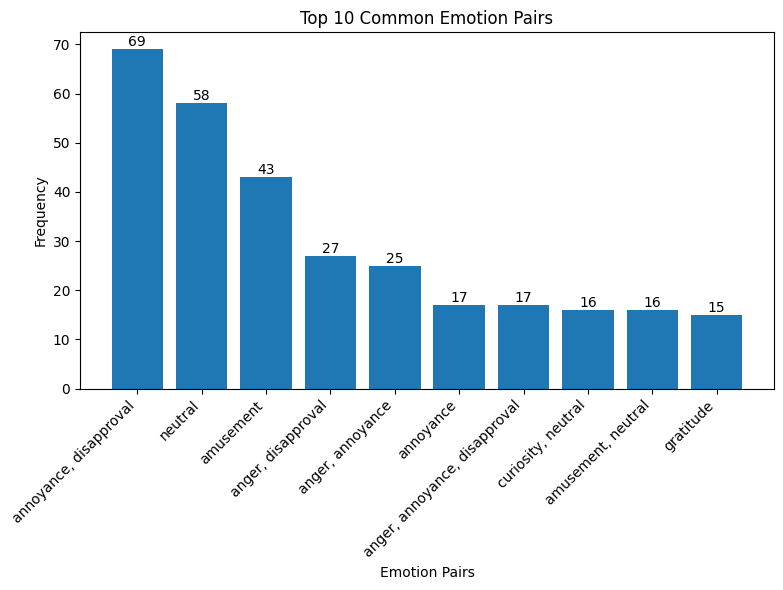

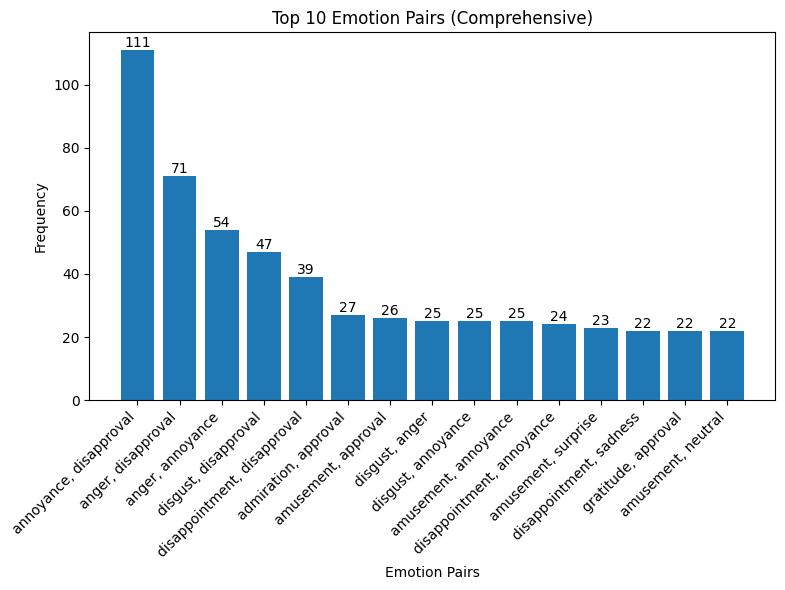

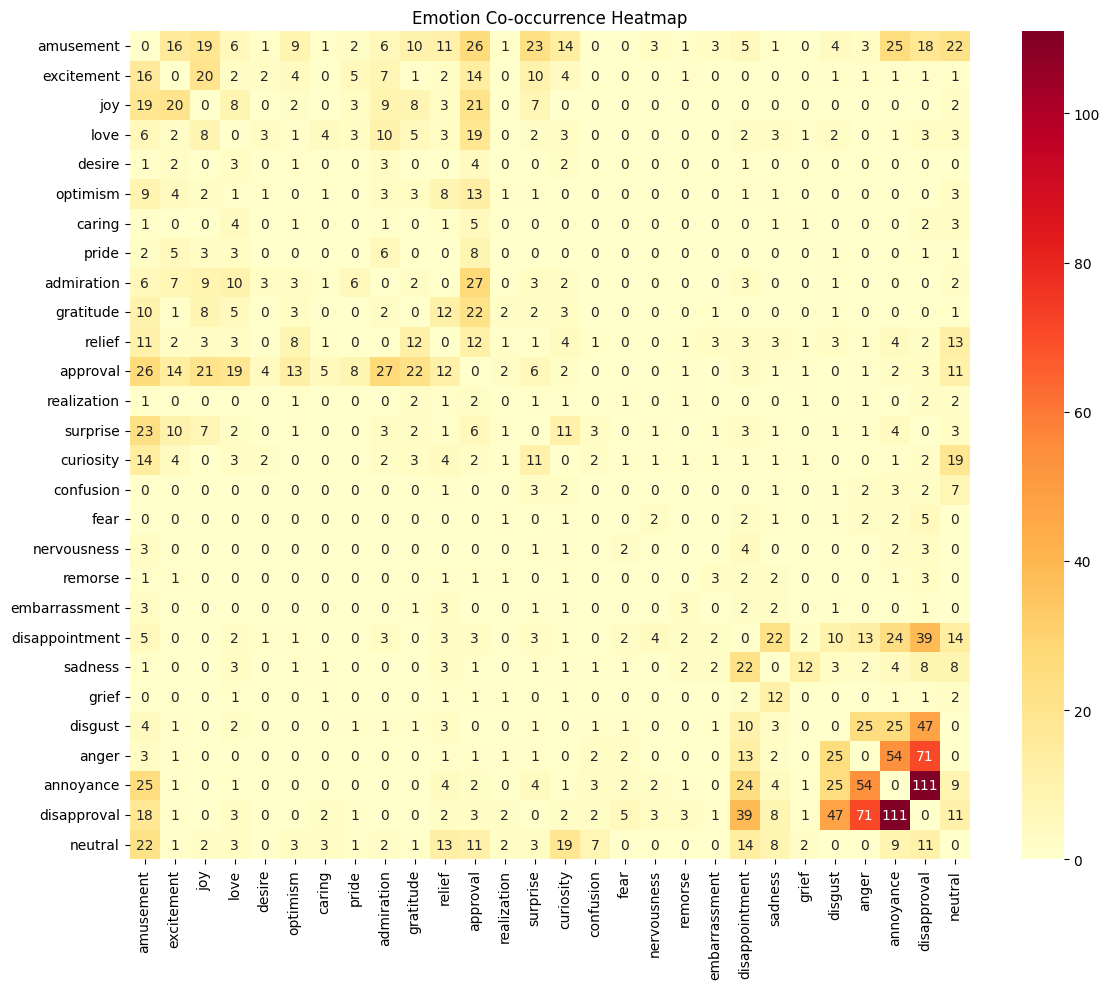


Top 10 Common Pairs
╒═══════════════════════════════╤═════════╕
│ Emotions                      │   Count │
╞═══════════════════════════════╪═════════╡
│ annoyance, disapproval        │      69 │
├───────────────────────────────┼─────────┤
│ neutral                       │      58 │
├───────────────────────────────┼─────────┤
│ amusement                     │      43 │
├───────────────────────────────┼─────────┤
│ anger, disapproval            │      27 │
├───────────────────────────────┼─────────┤
│ anger, annoyance              │      25 │
├───────────────────────────────┼─────────┤
│ annoyance                     │      17 │
├───────────────────────────────┼─────────┤
│ anger, annoyance, disapproval │      17 │
├───────────────────────────────┼─────────┤
│ curiosity, neutral            │      16 │
├───────────────────────────────┼─────────┤
│ amusement, neutral            │      16 │
├───────────────────────────────┼─────────┤
│ gratitude                     │      15 │
╘══════════

In [20]:
# Main execution
file_path = 'run2/train_neutralized_filtered.csv'  # Replace with your actual file path
data = process_csv(file_path)

Number = 10
Print_Table = True

top_pairs = get_top_pairs(data, n=Number)
all_emotion_pairs = get_all_emotion_pairs(data)

plot_top_pairs(top_pairs, f"Top {Number} Common Emotion Pairs")
plot_top_pairs(all_emotion_pairs, f"Top {Number} Emotion Pairs (Comprehensive)")
plot_heatmap(get_all_emotion_pairs(data, n=len(EMOTIONS)**2))


if Print_Table:
    print_table(top_pairs, f"Top {Number} Common Pairs")
    print_table(all_emotion_pairs, f"Top {Number} Pairs of Emotions (Comprehensive)")
